In [1]:
from sdapy.ztfanalysis import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# use ztfsingle to do fits step by step

### redshift, distance module and milky way ebv is needed

In [110]:
ztfid = 'ZTF20abqdkne'
ztfm = ztfmultiple(datadir='/Users/yash0613/Library/CloudStorage/Box-Box/ztf_data/',
                   metafile='rcf_query.txt', verbose=True)
ztfm.parse_meta()
ztfm.format_meta()

meta 142 objs


### show flux and mag plots

In [111]:
# initialize class
ztfm.parse_params(force=True)
par = dict()
if ztfid in ztfm.params: par = ztfm.params[ztfid]

ztfp = ztfsingle(ztfid=ztfid, iauid=ztfm.meta['IAUID'][ztfid], 
                 z=ztfm.meta['redshift'][ztfid],
                 dm=ztfm.meta['dm'][ztfid],
                 mkwebv=ztfm.meta['ebv'][ztfid],
                 sntype=ztfm.meta['type'][ztfid], 
                 ra='05:36:11.52', dec='+51:37:01.3', **par)
ztfp.get_fp_ztf()

{}

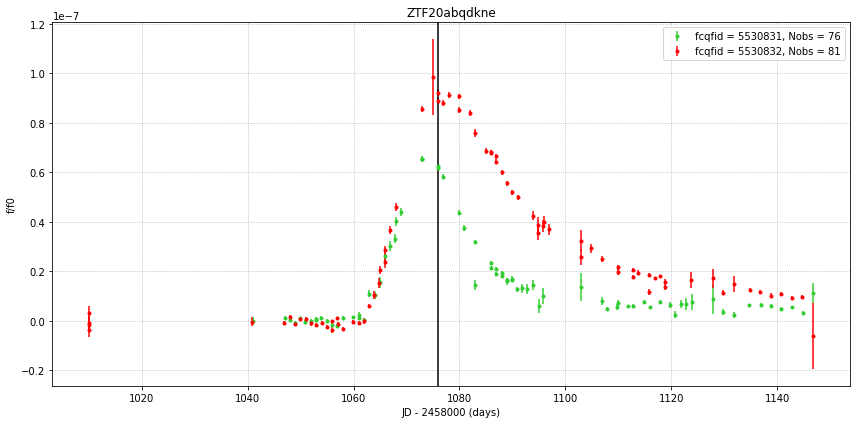

In [116]:
def plotlcs(tb, name, seeing_cut = 7., xp=None, xmin=20, xmax=70):
    tb = tb[tb.seeing<seeing_cut]
    fcqfs = np.unique(tb['fcqfid'].values)
    colors_g = ['limegreen', 'c', 'skyblue']
    colors_r = ['r', 'm', 'pink']
    colors_i = ['gold', 'orange', 'y']
    plt.figure(figsize=(12,6))
    ax = plt.gca()
    baseline = dict()
    for fcqfid in fcqfs:
        ix = tb['fcqfid'].values==fcqfid
        if fcqfid % 10 ==1:
            color=colors_g[0]
            colors_g = colors_g[1:]
        elif fcqfid % 10 == 2:
            color=colors_r[0]
            colors_r = colors_r[1:]
        else:
            color=colors_i[0]
            colors_i = colors_i[1:]
        thistime = (tb['jdobs'][ix] - 2458000)
        plt.errorbar(thistime, tb['Fratio'][ix], tb['Fratio_unc'][ix], 
                     fmt='.', color=color, label = 'fcqfid = %d, Nobs = %d'%(fcqfid, np.sum(ix)))
        # baseline
        if xmin is None or xmax is None:continue
        __ = np.logical_and(tb['jdobs'][ix]>=xp+xmin, tb['jdobs'][ix]<=xp+xmax)
        if len(tb['jdobs'][ix][__]) > 0:
            xx = tb['jdobs'][ix][__] - 2458000
            yy = tb['Fratio'][ix][__]
            yye = tb['Fratio_unc'][ix][__]
            plt.errorbar(xx, yy, yye, marker='o', markersize=12, ls='', fillstyle='none', color=color)
            y0 = np.average(yy, weights=1/yye/yye)
            ax.axhline(y0, color=color)
            baseline[fcqfid] = y0
    if xp is not None: 
        ax.axvline(xp-2458000, color='k', ls='-')
        if xmin is not None and xmax is not None:
            assert xmin < xmax
            ax.axvline(xp+xmin-2458000, color='r', ls='--')
            ax.axvline(xp+xmax-2458000, color='r', ls='--')
    ylims1 = ax.get_ylim()
    plt.ylim(ylims1[0], ylims1[1])
    plt.grid(ls=":")
    plt.xlabel('JD - 2458000 (days)')
    plt.ylabel('f/f0')
    plt.legend(loc = 'best')
    plt.title(name)
    plt.tight_layout()
    return baseline

jdpeak = ztfm.meta['peakt'][ztfid] + 2458000
baseline = plotlcs(ztfp.lc, ztfp.ztfid, seeing_cut = 7., xp=jdpeak, xmin=None, xmax=None)
baseline

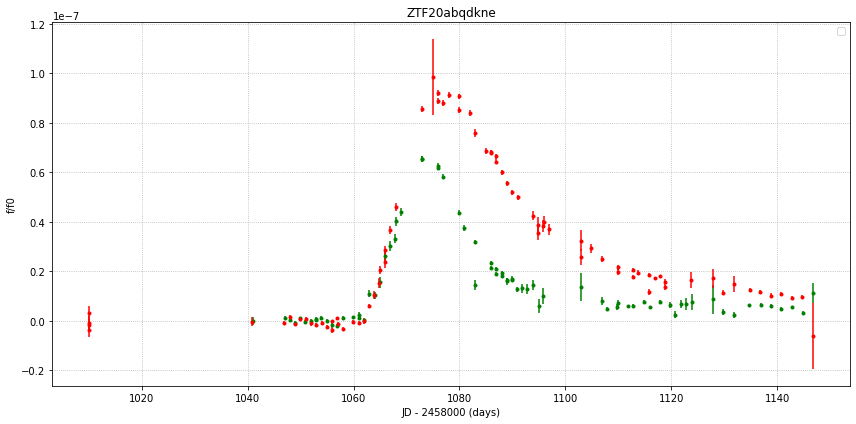

In [117]:
def plotlcs(tb, name, seeing_cut = 7., baseline=None):
    tb = tb[tb.seeing<seeing_cut]
    fcqfs = np.unique(tb['fcqfid'].values)
    plt.figure(figsize=(12,6))
    ax = plt.gca()
    for fcqfid in fcqfs:
        ix = tb['fcqfid'].values==fcqfid
        if fcqfid % 10 ==1:
            color='g'
        elif fcqfid % 10 == 2:
            color='r'
        else:
            color='k'
        ys=0
        if baseline is not None and fcqfid in baseline:
            ys = baseline[fcqfid]
        thistime = (tb['jdobs'][ix] - 2458000)
        plt.errorbar(thistime, tb['Fratio'][ix]-ys, tb['Fratio_unc'][ix], 
                     fmt='.', color=color)
    ylims1 = ax.get_ylim()
    plt.ylim(ylims1[0], ylims1[1])
    plt.grid(ls=":")
    plt.xlabel('JD - 2458000 (days)')
    plt.ylabel('f/f0')
    plt.legend(loc = 'best')
    plt.title(name)
    plt.tight_layout()
    return baseline

plotlcs(ztfp.lc, ztfp.ztfid, seeing_cut = 7., baseline=None)

In [ ]:
# initialize class
ztfm.parse_params(force=True)
par = dict()
if ztfid in ztfm.params: par = ztfm.params[ztfid]

ztfp = ztfsingle(ztfid=ztfid, iauid=ztfm.meta['IAUID'][ztfid], 
                 z=ztfm.meta['redshift'][ztfid],
                 dm=ztfm.meta['dm'][ztfid],
                 mkwebv=ztfm.meta['ebv'][ztfid],
                 sntype=ztfm.meta['type'][ztfid], **par)

# get forced lightcurves
sigma = 5
df = pd.read_csv('/Users/yash0613/Desktop/%s_fnu.csv'%ztfid,sep=',')
df.rename(columns={'jd':'jdobs',
                   'fnu_microJy':'Fpsf',
                   'fnu_microJy_unc':'Fpsf_unc',
                   'zpdiff':'zp',
                   'sys_unc_factor': 'ezp',
                   'passband': 'filter'}, inplace=True)
        
mags, sigmamags, limmags, filters, frat, efrat = [], [], [], [], [], []
for _ in df.index:
    flux, fluxerr, filtro, zpdiff = df['Fpsf'][_], df['Fpsf_unc'][_], \
                                    df['filter'][_], df['zp'][_]
    snr = flux / fluxerr
    zpdiff = 23.9
    F0 = 10**(zpdiff/2.5)
    Fratio = flux / F0
    eFratio = fluxerr / F0
    if flux > 0 and snr > sigma:
        magpsf = -2.5*np.log10(flux) + zpdiff
        sigmamagpsf = abs(-2.5/np.log(10) * fluxerr / flux)
    else:
        magpsf = 99
        sigmamagpsf = 99
    limmag = -2.5*np.log10(sigma*fluxerr) + zpdiff
    mags.append(magpsf)
    sigmamags.append(sigmamagpsf)
    limmags.append(limmag)
    filters.append(filtro.replace('ZTF_',''))    
    frat.append(Fratio)
    efrat.append(eFratio)
df['mag'] = mags
df['emag'] = sigmamags
df['limmag'] = limmags
df['filter'] = filters
df['Fratio'] = frat
df['Fratio_unc'] = efrat
ztfp.lc = df

ztfp.add_flux()
ztfp.init_fig()
ztfp.on_sntype() # check sn type   
ztfp.run_gp()     # Gaussian process
ztfp.set_t0_withgp()
ztfp.set_texp_midway() # try to set texp    
ztfp.run_fit()   # sn-like analytic functions
ztfp.explosion_pl()  # power law for first light
ztfp.calc_colors()  # g-r colour epochs
ztfp.est_host_c10()   # use g-r compared to tpl for host ebv
ztfp.lyman_bol()  # calculate luminosity from g,r with Lyman bol correction
ztfp.arnett_fit() # fit lums around peak to arnett model
ztfp.tail_fit()   # fit lums at tail to gamma leakage model
ztfp.get_local_spectra()  # obtain local spectra
ztfp.meas_specline()  # measure specific lines, fit photos v to break arnett degenaracy
ztfp.plot()   # plot everything